Colin Jemmott for Seismic, Aug 2020

Working with the hybrid recommender LightFM, I have been finding that every category of item features I try gives worse performance than no item features at all. This notebook is an attempt to reproduce that with a public dataset so I can ask for help.

Code was thrown together quickly, and is kinda rough.  Feel free to ask me if you have questions.  cjemmott@seismic.com

In [77]:
import numpy as np
import pandas as pd
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm import evaluation
from sklearn.model_selection import train_test_split

In [101]:
randomSeed = 12

## Data pipeline

In [76]:
# Load
books = pd.read_csv("books.csv").set_index("goodreads_book_id")
ratings = pd.read_csv("ratings.csv").set_index("book_id")
# join
df = ratings.join(books, how="inner")
# Trim (for speed)
df = df[df['user_id'] < 5000]

In [73]:
# Make the item feature

authorDf = df[['authors', 'book_id']].drop_duplicates()

itemFeatureAssignments = [] # item, feature tuples
itemFeatureList = [] # list of unique item feature values
for ii in range(len(authorDf)):
    itemFeatureAssignments.append((authorDf['book_id'].iloc[ii], 
                          authorDf['authors'].iloc[ii].split(", ")))
    itemFeatureList.extend(authorDf['authors'].iloc[ii].split(", "))

itemFeatureList = set(itemFeatureList)

itemFeatureAssignments[:10]

[(27, ['J.K. Rowling', 'Mary GrandPré']),
 (21, ['J.K. Rowling', 'Mary GrandPré']),
 (2, ['J.K. Rowling', 'Mary GrandPré']),
 (18, ['J.K. Rowling', 'Mary GrandPré', 'Rufus Beck']),
 (24, ['J.K. Rowling', 'Mary GrandPré']),
 (3275, ['J.K. Rowling', 'Mary GrandPré']),
 (3753, ['J.K. Rowling']),
 (54, ['Douglas Adams']),
 (337, ['Douglas Adams']),
 (374, ['Bill Bryson'])]

In [74]:
# Make LightFM dataset
dataset = Dataset()
dataset.fit(users = df['user_id'],
            items = df['book_id'],
            item_features = itemFeatureList,
           )
item_features = dataset.build_item_features(itemFeatureAssignments)

## Helper function to calculate performance

In [144]:
# Define performane metrics
def getMetrics(model, train, test, item_features, fullMetrics = False):
    # Details: https://making.lyst.com/lightfm/docs/lightfm.evaluation.html
    metrics = {}
    
    # run with no item or user features, which is CF
    model_cf = LightFM(loss='warp', random_state = randomSeed)
    model_cf.fit(train, epochs=numEpochs) 

    # MRR
    test_mrr = evaluation.reciprocal_rank(model, 
                                          test, 
                                          train_interactions=train,
                                          item_features=item_features).mean()
    #print('MRR: {:.3f}'.format(test_mrr))
    # Compare to CF
    mrr_cf = evaluation.reciprocal_rank(model_cf, test, train_interactions=train).mean()
    metrics["MRR Improvement"] = 100*(test_mrr/mrr_cf-1)

    """
    # Area under ROC
    test_auc = evaluation.auc_score(model, 
                                          test, 
                                          train_interactions=train,
                                          item_features=item_features).mean()
    #print('AUC: {:.3f}'.format(test_auc))
    auc_cf = evaluation.auc_score(model_cf, test, train_interactions=train).mean()
    metrics["AUC Improvement"] = 100*(test_auc/auc_cf-1)


    # Recall at k
    k = 5
    test_rak = evaluation.recall_at_k(model, 
                                      test, 
                                      train_interactions=train,
                                      item_features=item_features, 
                                      k=k).mean()
    rak_cf = evaluation.recall_at_k(model_cf, test, train_interactions=train, k=k).mean()
    metrics['R@{} Improvement'.format(k)] = 100*(test_rak/rak_cf-1)
    """  
    return metrics

## Train and test

In [145]:
trainDf, testDf = train_test_split(df, train_size=0.8)
train, _ = dataset.build_interactions(list(zip(trainDf['user_id'], trainDf['book_id'])))
test, _ = dataset.build_interactions(list(zip(testDf['user_id'], testDf['book_id'])))

In [148]:
numEpochs = 1

model = LightFM(loss='warp', 
          learning_rate=0.05,
          random_state = randomSeed)
model.fit(train, 
          epochs=numEpochs, 
          item_features=item_features
         ) 
mrrActual = getMetrics(model, train, test, item_features)['MRR Improvement']
mrrActual

-11.423325538635254

## Shuffle authors

the idea here is to see if randomly assigned labels are actually _better_.

I did it before making the list - I guess I could do the shuffle the other way, but I don't know if it would matter?

In [160]:
mrrResults = []
for _ in range(100):
    shuffleDf = authorDf
    shuffleDf['authors'] = np.random.permutation(shiffleDf['authors'])

    # Make the item feature
    itemFeatureAssignments = [] # item, feature tuples
    for ii in range(len(shuffleDf)):
        itemFeatureAssignments.append((shuffleDf['book_id'].iloc[ii], 
                              shuffleDf['authors'].iloc[ii].split(", ")))

    item_features = dataset.build_item_features(itemFeatureAssignments)
    
    model = LightFM(loss='warp', 
              learning_rate=0.05,
              random_state = randomSeed)
    model.fit(train, 
              epochs=numEpochs, 
              item_features=item_features
             ) 
    mrrResults.append(getMetrics(model, train, test, item_features)['MRR Improvement'])

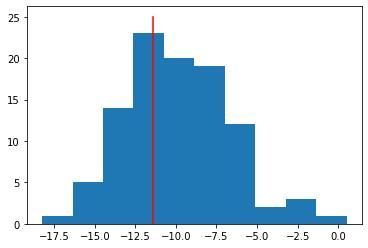

In [162]:
import matplotlib.pyplot as plt
_ = plt.hist(mrrResults)
plt.plot([mrrActual,mrrActual],[0,25], c='r')

## Add the identity matrix in to be safe

Added `book_id` to 

In [173]:
# Make the item feature

authorDf = df[['authors', 'book_id']].drop_duplicates()

itemFeatureAssignments = [] # item, feature tuples
for ii in range(len(authorDf)):
    itemFeatureAssignments.append((authorDf['book_id'].iloc[ii], 
                          authorDf['authors'].iloc[ii].split(", ") + [authorDf['book_id'].iloc[ii]]))

model = LightFM(loss='warp', 
          learning_rate=0.05,
          random_state = randomSeed)
model.fit(train, 
          epochs=numEpochs, 
          item_features=item_features
         ) 
mrrActual = getMetrics(model, train, test, item_features)['MRR Improvement']
mrrActual

-5.40614128112793

In [170]:
mrrResults = []
for _ in range(100):
    shuffleDf = authorDf
    shuffleDf['authors'] = np.random.permutation(shiffleDf['authors'])

    # Make the item feature
    itemFeatureAssignments = [] # item, feature tuples
    for ii in range(len(shuffleDf)):
        itemFeatureAssignments.append((shuffleDf['book_id'].iloc[ii], 
                              shuffleDf['authors'].iloc[ii].split(", ") + [shuffleDf['book_id'].iloc[ii]]))

    item_features = dataset.build_item_features(itemFeatureAssignments)
    
    model = LightFM(loss='warp', 
              learning_rate=0.05,
              random_state = randomSeed)
    model.fit(train, 
              epochs=numEpochs, 
              item_features=item_features
             ) 
    mrrResults.append(getMetrics(model, train, test, item_features)['MRR Improvement'])

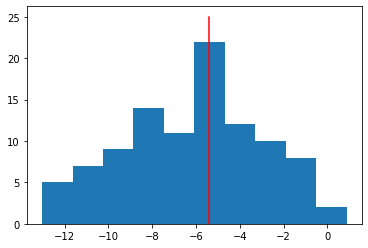

In [174]:
import matplotlib.pyplot as plt
_ = plt.hist(mrrResults)
plt.plot([mrrActual,mrrActual],[0,25], c='r')

641